## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
# Note: Jupyter Notebook created using Monokai dark theme from JupyterThemes package
# The below will set up styles for plots for viewability on a dark background
from jupyterthemes import jtplot
jtplot.style('monokai')

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [6]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
df.query('(landing_page == "new_page" & group != "treatment") | '
         '(landing_page != "new_page" & group == "treatment")').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2 = df.query('(landing_page == "new_page" & group == "treatment") | '
               '(landing_page == "old_page" & group == "control")').copy()

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.drop_duplicates(subset=['user_id'])
df2['user_id'].duplicated().sum()

0

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2.query('landing_page == "new_page"')['user_id'].count() / df2['user_id'].count()

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

Based only on the results above, it appears that the new landing page has practically very little effect on user conversion. The independent probability of conversion, and the dependent probabilities of conversion all rounded to the nearest tenth of a percent at 12.0%, indicating that the page the user lands on makes little difference to the conversion rate.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H_{0}: p_{new} - p_{old}  \leqslant 0 $ <br>
$H_{1}: p_{new} - p_{old} > 0 $

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = p_new

c. What is $n_{new}$?

In [21]:
n_new = df2.query('landing_page == "new_page"')['user_id'].count()
n_new

145310

d. What is $n_{old}$?

In [22]:
n_old = df2.query('landing_page == "old_page"')['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([1, 0], size=n_new, replace=True, p=[p_new, 1-p_new])
new_page_converted.mean()

0.11959947698024913

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([1, 0], size=n_old, replace=True, p=[p_old, 1-p_old])
old_page_converted.mean()

0.11932623869377865

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean() - old_page_converted.mean()

0.0002732382864704813

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
p_diffs = []

for i in np.arange(0, 10000):
    # Using np.random.binomial() to simulate as it is faster for multiple iterations
    # Per suggestion of Ong K. in Peer Project Help chatroom
    new_pages = np.random.binomial(n_new, p_new, size=10000)
    old_pages = np.random.binomial(n_old, p_old, size=10000)
    p_diff = ((new_pages.mean() / new_pages.shape[0]) -  
              (old_pages.mean() / old_pages.shape[0]))
    p_diffs = np.append(p_diffs, p_diff)

p_diffs

array([0.00050077, 0.0007506 , 0.00059618, ..., 0.00029362, 0.00054099,
       0.0003877 ])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

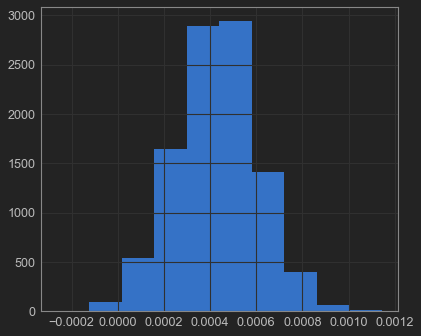

In [27]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
old_rate = df2.query('group == "control"')['converted'].mean()
new_rate = df2.query('group == "treatment"')['converted'].mean()

obs_diff = new_rate - old_rate

prob_high = (p_diffs > obs_diff).mean()
prob_high

1.0

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

In part j, we simulated the null distribution based on the null hypothesis and stored it in p_diffs. By calculating the percentage of p_diffs that falls over the observed difference, we calculate the probability that the null-hypothesised values generated the sample statistics. This is called the p-value.

As the calculated value is 1.0, this means that the null-hypothesised values are very likely to have generated the sample statistic, therefore there is no evidence to suggest rejecting the null hypothesis for the alternate hypothesis; i.e. there is no evidence to suggest that the new page performs better than the old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].mean()
convert_new = df2.query('group == "treatment"')['converted'].mean()
n_old = df2.query('group == "control"')['user_id'].count()
n_new = df2.query('group == "treatment"')['user_id'].count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
stat, pval = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], 
                                        alternative='larger')
print(stat, pval)

-0.0032875796753531767 0.5013115521701044


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

the z-score is lower than the 5% confidence level of 1.645, and the p-value is too large for the 5% significance level, so the result is consistent with parts j and k that there is not enough evidence to suggest rejecting the null hypothesis at the 5% significance level or at any reasonable level.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

A logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
ab_page = pd.get_dummies(df2['group'])
df3 = pd.merge(df2, ab_page, left_index=True, right_index=True)
df3.rename(columns={'treatment':'ab_page'}, inplace=True)

X = df3['ab_page']
X = sm.add_constant(X)
y = df3['converted']

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [32]:
mod = sm.Logit(y, X)
res = mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
print(res.summary2())

                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-01-13 02:49 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
const        -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074



e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value of ab_page is lower than the p-value obtained in Part II, although it is still not significant at a 5% significance level. However, at 0.1899 it can be considered to be significant at 20% significance level (although that would be an uncommonly high level to use). 

However, it appears that the new page actually has a negative effect on the conversion rate, with a coefficience of -0.0150, implying that the new page only has a 98.5% of the conversion rate of the old page (exponent of -0.0150), i.e. worse by 1.5%.

For the logistic regression model, the p-value on the ab_page variable is based on a 2-sided test whether the coefficient is statistically different from zero, while in Part II the testing was a 1-sided test whether the conversion rate of the new page is statistically higher than the conversion rate of the old page. 

In terms of null and alternative hypotheses, the p-value in the regression tests for: <br>
$H_{0}: b_{1} = 0$ <br>
$H_{1}: b_{1} \neq 0$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Adding additional terms could help to improve the explanatory power of the model, but it could also introduce the problem of multicollinearity if one or more of the explanatory variables are correlated to each other.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [34]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [35]:
ab_page = pd.get_dummies(df_new['group'])
df3 = pd.merge(df_new, ab_page, left_index=True, right_index=True)
df3.rename(columns={'treatment':'ab_page'}, inplace=True)

country = pd.get_dummies(df_new['country'])
df4 = pd.merge(df3, country, left_index=True, right_index=True)

X = df4[['ab_page', 'UK', 'CA']]
y = df4['converted']
X = sm.add_constant(X)

mod = sm.Logit(y, X)
res = mod.fit()

print(res.summary2())

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-01-13 02:49 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
const        -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912

Based on the p-values of the country dummy variables, with the US as the base country, the user being in the UK does not seem to have statistically significant effect with a p-value of 0.46, but the user being in Canada has a statistically significant effect if using significance level of 20%.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [36]:
df4['inter_ab_page_UK'] = df4['ab_page'] * df4['UK']
df4['inter_ab_page_CA'] = df4['ab_page'] * df4['CA']
df4['inter_ab_page_US'] = df4['ab_page'] * df4['US']

X = df4[['ab_page', 'UK', 'CA', 'inter_ab_page_UK', 'inter_ab_page_CA']]
y = df4['converted']
X = sm.add_constant(X)

mod = sm.Logit(y, X)
res = mod.fit()

print(res.summary2())

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-01-13 02:49 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
const            -1.9865   0.0096 -206.3440 0.0000 -2.0053 -1.9676
ab_page          -0.0206   0.0137   -1.5052 0.1323 -0

The p-values of the country and the interaction dummy variables worsens compared to the regression that uses only the page and country variables, suggesting that the interaction variables are not appropriate.

<a id='conclusions'></a>
## Conclusions

Based on the regression with dummy variables for new page, countries, as well as interactions between new page and countries, it appears that while there are evidences that there are statistical significance if the significance level is high enough (20%), the corresponding confidence level at 80% is too low for most statistical analyses.

Additionally, the regression seems to suggest that the new page actually has a worse conversion rate compared to the old page. In the practical sense, this means that there is no convincing argument for rolling out the new page. However, this may be an effect of change aversion, and, given a longer test period, it may be possible that the conversion rate of the new page versus the old page may improve.